<a href="https://colab.research.google.com/github/narpat78/DCGAN-CelebFaces/blob/main/DCGAN_Face_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Mounting Google Drive to Access the Dataset

In [ ]:
# mounting drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Unzipping the Dataset Folder

In [ ]:
# unzipping dataset folder
import zipfile
import os

zip_path = '/content/drive/MyDrive/DCGAN_Faces/processed-celeba-small.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f'Images Unzipped at: {extract_path}processed_celeba_small/')

Images Unzipped at: /content/processed_celeba_small/


#### Importing Required Dependencies

In [ ]:
# importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torch.optim as optim

#### DataLoader for Loading and Preprocessing the Dataset

In [ ]:
# dataloader
def get_dataloader(batch_size, image_size):
    # Step 1: Set up the transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(image_size),  # Resize images to image_size x image_size
        transforms.ToTensor(),  # Convert image to tensor
    ])
    # Step 2: Load the dataset
    dataset = datasets.ImageFolder(root='/content/processed_celeba_small', transform=transform)
    # Step 3: Create the DataLoader (with batching and shuffling)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    # Step 4: Return the DataLoader to be used later
    return dataloader

In [ ]:
# creating the dataloader
batch_size = 32
img_size = 32

# dataloader
celeba_train_loader = get_dataloader(batch_size, img_size)

#### Data Visualization

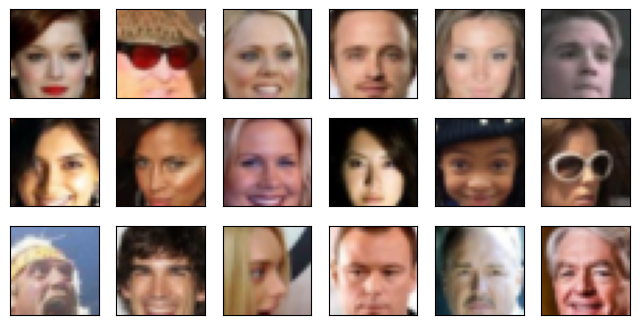

In [ ]:
# one batch of training images
data_iter = iter(celeba_train_loader)
images, _ = next(data_iter)

# plotting the dataset
fig = plt.figure(figsize=(8,4))
for idx in np.arange(18):
    ax = fig.add_subplot(3, 6, idx + 1, xticks=[], yticks=[])
    image_np = images[idx].numpy()
    plt.imshow(np.transpose(image_np, (1,2,0)))

#### Data Preprocessing

In [ ]:
# function to scale the image pixels
def scale_pixels(x, feature_range=(-1, 1)):
    """scales the image pixels from [0,1] to [-1,1]"""
    feature_range = (-1,1)
    x = (x-0.5) * (feature_range[1]-feature_range[0])
    return x

In [ ]:
# scaling the image pixels
img = images[0]
scaled_img = scale_pixels(img)

print('Minimum Scaled Pixel Value:', scaled_img.min())
print('Maximum Scaled Pixel Value:', scaled_img.max())

Minimum Scaled Pixel Value: tensor(-1.)
Maximum Scaled Pixel Value: tensor(0.7882)


#### Discriminator Model

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim):
        """
        Initialize the Discriminator Module
        :param conv_dim: The depth of the first convolutional layer
        """
        super(Discriminator, self).__init__()

        self.conv1 = nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1, bias=False)  # 32x32 -> 16x16
        self.conv2 = nn.Conv2d(conv_dim, conv_dim*2, kernel_size=4, stride=2, padding=1, bias=False)  # 16x16 -> 8x8
        self.conv3 = nn.Conv2d(conv_dim*2, conv_dim*4, kernel_size=4, stride=2, padding=1, bias=False)  # 8x8 -> 4x4

        # BatchNorm layers
        self.batch_norm1 = nn.BatchNorm2d(conv_dim*2)  # Apply batch norm after 2nd layer
        self.batch_norm2 = nn.BatchNorm2d(conv_dim*4)  # Apply batch norm after 3rd layer

        # fully connected layer (output layer)
        self.fc = nn.Linear(conv_dim*4*4*4, 1)  # Flattened into 1 for real/fake classification

    def forward(self, x):
        """
        Forward propagation of the neural network
        :param x: The input to the neural network
        :return: Discriminator logits; the output of the neural network
        """
        # Apply convolutions + Leaky ReLU activations
        x = F.leaky_relu(self.conv1(x), 0.2)  # First layer, no batch normalization
        x = F.leaky_relu(self.batch_norm1(self.conv2(x)), 0.2)  # Second layer with batch normalization
        x = F.leaky_relu(self.batch_norm2(self.conv3(x)), 0.2)  # Third layer with batch normalization

        # Flatten the output to feed it into the fully connected layer
        x = x.view(x.size(0), -1)  # Flatten (batch_size, channels, height, width) -> (batch_size, features)

        # Final fully connected layer to get the output
        x = self.fc(x)
        return x

#### Generator Model

In [ ]:
class Generator(nn.Module):

    def __init__(self, z_size, conv_dim):
        """
        Initialize the Generator Module
        :param z_size: Length of the input latent vector z
        :param conv_dim: Depth of the inputs to the last transpose conv layer
        """
        super(Generator, self).__init__()
        self.conv_dim = conv_dim

        # Fully connected layer to go from z to a deep feature map
        self.fc = nn.Linear(z_size, conv_dim * 4 * 4 * 4)

        # Transposed convolutional layers
        self.t_conv1 = nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, 4, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(conv_dim * 2)

        self.t_conv2 = nn.ConvTranspose2d(conv_dim * 2, conv_dim, 4, stride=2, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(conv_dim)

        self.t_conv3 = nn.ConvTranspose2d(conv_dim, 3, 4, stride=2, padding=1, bias=False)

    def forward(self, x):
        """
        Forward propagation of the generator
        :param x: Input latent vector (z)
        :return: Generated image (batch_size, 3, 32, 32)
        """
        out = self.fc(x)
        out = out.view(-1, self.conv_dim * 4, 4, 4)  # Reshape to feature map

        out = F.relu(self.bn1(self.t_conv1(out)))  # 4x4 -> 8x8
        out = F.relu(self.bn2(self.t_conv2(out)))  # 8x8 -> 16x16
        out = torch.tanh(self.t_conv3(out))        # 16x16 -> 32x32 with 3 channels

        return out

#### Weight Initialization
To ensure stable convergence during training, we apply weight initialization to all the convolutional and linear layers in the Generator and Discriminator modles.

The weights are initialized using a zero-centered normal distribution with a standard deviation of 0.02, as in the original DCGAN paper.

In [ ]:
# weight initialization
def weights_init_normal(m):
    """
    Applies initial weights to certain layers in a model .
    The weights are taken from a normal distribution
    with mean = 0, std dev = 0.02.
    :param m: A module or layer in a network
    """
    # classname will be something like:
    # `Conv`, `BatchNorm2d`, `Linear`, etc.
    classname = m.__class__.__name__

    # TODO: Apply initial weights to convolutional and linear layers
    init_type='normal'
    init_gain=0.02

    if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            if init_type == 'normal':
                init.normal_(m.weight.data, 0.0, init_gain)
            elif init_type == 'xavier':
                init.xavier_normal_(m.weight.data, gain=init_gain)
            elif init_type == 'kaiming':
                init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                init.orthogonal_(m.weight.data, gain=init_gain)
            else:
                raise NotImplementedError('initialization method [%s] is not implemented' % init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm2d') != -1:  # BatchNorm Layer's weight is not a matrix; only normal distribution applies.
        init.normal_(m.weight.data, 1.0, init_gain)
        init.constant_(m.bias.data, 0.0)

#### Building the Complete Network

In [ ]:
# hyperparameters
d_conv_dim = 32
g_conv_dim = 32
z_size = 100

In [ ]:
# discriminator model
D = Discriminator(d_conv_dim)
D.apply(weights_init_normal)

Discriminator(
  (conv1): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

In [ ]:
# generator model
G = Generator(z_size=z_size, conv_dim=g_conv_dim)
G.apply(weights_init_normal)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (t_conv1): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_conv3): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)

#### Training on GPU

In [ ]:
# Check for a GPU
gpu = torch.cuda.is_available()
if not gpu:
    print('GPU not found.')
else:
    print('GPU found.')

GPU found.


#### Discriminator and Generator Loss

- For the discriminator, the total loss is the sum of the losses for real and fake images, d_loss = d_real_loss + d_fake_loss.
- The generator tries to fool the discriminator into thinking that its fake images are real.

In [ ]:
def real_loss(D_out, smooth=True):
    '''Calculates how close discriminator outputs are to being real.
       param, D_out: discriminator logits
       return: real loss'''
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1

    # move labels to GPU if available
    if gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

In [ ]:
def fake_loss(D_out):
    '''Calculates how close discriminator outputs are to being fake.
       param, D_out: discriminator logits
       return: fake loss'''
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

#### Optimizers

In [ ]:
# optimizers for the discriminator D and generator G
lr = 0.001
beta1=0.1
beta2=0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

#### Training

In [ ]:
def train(D, G, n_epochs, print_every=50):
    '''Trains adversarial networks for some number of epochs
       param, D: the discriminator network
       param, G: the generator network
       param, n_epochs: number of epochs to train for
       param, print_every: when to print and record the models' losses
       return: D and G losses'''

    # move models to GPU
    if gpu:
        D.cuda()
        G.cuda()

    # keep track of loss and generated, "fake" samples
    samples = []
    losses = []

    # Get some fixed data for sampling. These are images that are held
    # constant throughout training, and allow us to inspect the model's performance
    sample_size=25
    fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
    fixed_z = torch.from_numpy(fixed_z).float()
    # move z to GPU if available
    if gpu:
        fixed_z = fixed_z.cuda()

    # epoch training loop
    for epoch in range(n_epochs):

        # batch training loop
        for batch_i, (real_images, _) in enumerate(celeba_train_loader):

            batch_size = real_images.size(0)
            real_images = scale_pixels(real_images)

            # 1. Train the discriminator on real and fake images
            d_optimizer.zero_grad()

            # 1-1. Train with real images
            # Compute the discriminator losses on real images
            if gpu:
                real_images = real_images.cuda()

            D_real = D(real_images)
            d_real_loss = real_loss(D_real)

            # 1-2. Train with fake images
            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            # move x to GPU, if available
            if gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            D_fake = D(fake_images)
            d_fake_loss = fake_loss(D_fake)

            # add up loss and perform backprop
            d_loss = d_real_loss + d_fake_loss
            d_loss.backward()
            d_optimizer.step()

            # 2. Train the generator with an adversarial loss
            g_optimizer.zero_grad()

            # 2-1. Train with fake images and flipped labels

            # Generate fake images
            z = np.random.uniform(-1, 1, size=(batch_size, z_size))
            z = torch.from_numpy(z).float()
            if gpu:
                z = z.cuda()
            fake_images = G(z)

            # Compute the discriminator losses on fake images
            # using flipped labels!
            D_fake = D(fake_images)
            g_loss = real_loss(D_fake) # use real loss to flip labels

            # perform backprop
            g_loss.backward()
            g_optimizer.step()

            # Print some loss stats
            if batch_i % print_every == 0:
                # append discriminator loss and generator loss
                losses.append((d_loss.item(), g_loss.item()))
                # print discriminator and generator loss
                print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                        epoch+1, n_epochs, d_loss.item(), g_loss.item()))

        # generate and save sample, fake images
        G.eval() # for generating samples
        samples_z = G(fixed_z)
        samples.append(samples_z)
        G.train() # back to training mode

    # Save training generator samples
    with open('train_samples.pkl', 'wb') as f:
        pkl.dump(samples, f)

    # finally return losses
    return losses

In [ ]:
# number of epochs
n_epochs = 50

# training
losses = train(D, G, n_epochs=n_epochs)

Epoch [    1/   50] | d_loss: 1.4436 | g_loss: 2.3722
Epoch [    1/   50] | d_loss: 1.2988 | g_loss: 0.9043
Epoch [    1/   50] | d_loss: 1.1612 | g_loss: 1.4016
Epoch [    1/   50] | d_loss: 1.2828 | g_loss: 0.7301
Epoch [    1/   50] | d_loss: 1.7634 | g_loss: 0.7311
Epoch [    1/   50] | d_loss: 1.3709 | g_loss: 1.4602
Epoch [    1/   50] | d_loss: 1.6369 | g_loss: 0.5735
Epoch [    1/   50] | d_loss: 1.3538 | g_loss: 1.3345
Epoch [    1/   50] | d_loss: 1.3328 | g_loss: 1.0617
Epoch [    1/   50] | d_loss: 1.3094 | g_loss: 0.9723
Epoch [    1/   50] | d_loss: 1.3552 | g_loss: 0.9934
Epoch [    1/   50] | d_loss: 1.3393 | g_loss: 0.9005
Epoch [    1/   50] | d_loss: 1.4728 | g_loss: 0.8740
Epoch [    1/   50] | d_loss: 1.2999 | g_loss: 0.9129
Epoch [    1/   50] | d_loss: 1.4693 | g_loss: 0.8364
Epoch [    1/   50] | d_loss: 1.3334 | g_loss: 1.2055
Epoch [    1/   50] | d_loss: 1.4674 | g_loss: 1.2577
Epoch [    1/   50] | d_loss: 1.4757 | g_loss: 0.6126
Epoch [    1/   50] | d_loss

#### Plotting Training Loss

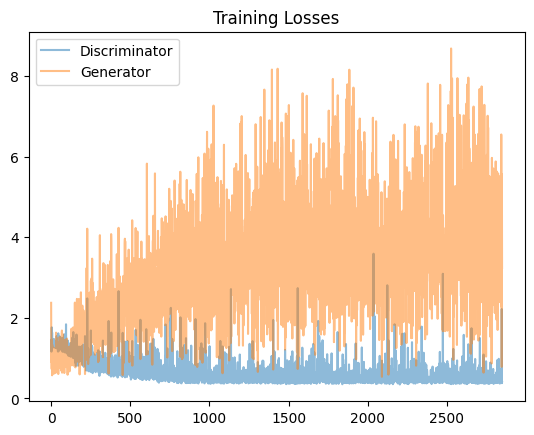

In [ ]:
# fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

#### Sample Images from the Generator

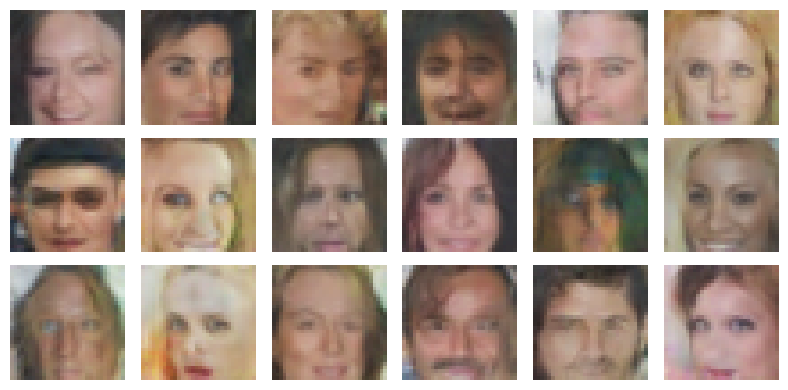

In [ ]:
# loading samples from generator
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)
# last set of generated images
generated_images = samples[-1]

# visualizing images
fig, axes = plt.subplots(3, 6, figsize=(8, 4), sharex=True, sharey=True)
for ax, img in zip(axes.flatten(), generated_images[:18]):
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))  # CHW to HWC
    img = ((img + 1) * 255 / 2).astype(np.uint8)  # Denormalize to [0, 255]
    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()